# [ATM 623: Climate Modeling](../index.ipynb)

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 10: Who needs spectral bands? We do. Some baby steps...

### About these notes:

This document uses the interactive [`Jupyter notebook`](https://jupyter.org) format. The notes can be accessed in several different ways:

- The interactive notebooks are hosted on `github` at https://github.com/brian-rose/ClimateModeling_courseware
- The latest versions can be viewed as static web pages [rendered on nbviewer](http://nbviewer.ipython.org/github/brian-rose/ClimateModeling_courseware/blob/master/index.ipynb)
- A complete snapshot of the notes as of May 2017 (end of spring semester) are [available on Brian's website](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2017/Notes/index.html).

[Also here is a legacy version from 2015](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/index.html).

Many of these notes make use of the `climlab` package, available at https://github.com/brian-rose/climlab

In [1]:
#  Ensure compatibility with Python 2 and 3
from __future__ import print_function, division

## Contents

1. [What if CO$_2$ actually behaved like a Grey Gas?](#section1)
2. [Another look at observed spectra](#section2)
3. [Water vapor changes under global warming](#section3)
4. [A simple water vapor parameterization](#section4)
5. [Modeling spectral bands with the `climlab.BandRCModel` process](#section5)

____________
<a id='section1'></a>

## 1. What if CO$_2$ actually behaved like a Grey Gas?
____________

Suppose that CO$_2$ actually behaved as a grey gas. In other words, no spectral dependence in absorptivity.

If we then **double the CO2 concentration** in the atmosphere, we double the number of absorbers. This should imply that we also **double the absorption cross-section**:

$$ \kappa^\prime = 2 ~ \kappa $$

This would imply that we **double the optical thickness of every layer**:

$$ \Delta \tau^\prime  = 2 \left( -\frac{\kappa}{g} \Delta p \right) = 2 ~ \Delta \tau$$ 

And since (from [Lecture 9](./Lecture09 -- Modeling non-scattering radiative transfer.ipynb)) the absorptivity / emissivity of each layer is

$$  \epsilon = 1 - \exp\big( - \Delta \tau \big)  $$

the **modified absorptivity** is

$$ \epsilon^\prime = 1 - \exp\big( - 2\Delta \tau \big) = 1 - \left( \exp\big( - \Delta \tau \big)\right)^2 = 1 - (1-\epsilon)^2 $$
or simply
$$ \epsilon^\prime = 2 \epsilon  - \epsilon^2 $$

(Note that $\epsilon^\prime = 2 \epsilon$ for very thin layers, for which $\epsilon$ is small).

### What does our 2-layer analytical model then say about the radiative forcing?

Recall that we tuned the two-layer model with

$$ \epsilon = 0.586 $$

to get the observed OLR with observed temperatures.

In [2]:
#  Applying the above formula
eps = 0.586
print( 'Doubling a grey gas absorber would \
       change the absorptivity from {:.3} \
       to {:.3}'.format(eps, 2*eps - eps**2))

Doubling a grey gas absorber would        change the absorptivity from 0.586        to 0.829


**If CO2 behaved like a grey gas**, doubling it would cause a huge increase in the absorptivity of each layer!

Back in [Lecture 7](./Lecture07 -- Elementary greenhouse models.ipynb)
we worked out that the radiative forcing in this model (with the observed lapse rate) is about +2.2 W m$^{-2}$ for an increase of 0.01 in $\epsilon$.

**This means that our hypothetical doubling of "grey CO$_2$" should yield a radiative forcing of 53.5 W m$^{-2}$.** 

This is an absolutely enormous number. Assuming a net climate feedback of -1.3 W m$^{-2}$ K$^{-1}$
(consistent with the AR5 ensemble)
would then give us an **equilibrium climate sensitivity of 41 K**.

### Conclusions:

1. **If CO2 did behave like a grey gas, we would be toast.**
2. The Grey Gas model is insufficient for understanding radiative forcing and feedback.

____________
<a id='section2'></a>

## 2. Another look at observed spectra
____________

It's time to move away from the Grey Gas approximation and look more carefully at the actual observed spectra of solar and terrestrial radiation.

### Observed solar spectra

The following figure shows observed spectra of solar radiation at TOA and at the surface, along with the theoretical Planck function for a blackbody at 5525 K.

<img src='../images/Solar_spectrum.png'>

> This figure shows the solar radiation spectrum for direct light at both the top of the Earth's atmosphere and at sea level. The sun produces light with a distribution similar to what would be expected from a 5525 K (5250 °C) blackbody, which is approximately the sun's surface temperature. As light passes through the atmosphere, some is absorbed by gases with specific absorption bands. Additional light is redistributed by Raleigh scattering, which is responsible for the atmosphere's blue color. These curves are based on the American Society for Testing and Materials (ASTM) Terrestrial Reference Spectra, which are standards adopted by the photovoltaics industry to ensure consistent test conditions and are similar to the light that could be expected in North America. Regions for ultraviolet, visible and infrared light are indicated.

Source: http://commons.wikimedia.org/wiki/File:Solar_spectrum_en.svg

- The figure shows that that the incident beam at TOA has the shape of a blackbody radiator. 
- By the time the beam arrives at the surface, it is strongly depleted at specific wavelengths.
- Absorption by O$_3$ (ozone) depletes almost the entire ultraviolet spectrum.
- Weaker absorption features, mostly due to H$_2$O, deplete some parts of the near-infrared.
- Note that the depletion in the visible band is mostly due to scattering, which depletes the direct beam but contributes diffuse radiation (so we can still see when it's cloudy!)

### Observed terrestrial spectra

This figure shows the Planck function for Earth's surface temperature compared with the spectrum observed from space.

<img src='../images/Terrestrial_spectrum.png'>

Source: https://www.e-education.psu.edu/earth103/node/671

Careful: I'm pretty sure what is plotted here is not the **total** observed spectrum, but rather the part of the **emissions from the surface** that **actual make it out to space**.

As we now, the terrestrial beam from the surface is depleted by absorption by many greenhouse gases, but principally CO$_2$ and H$_2$O.

However there is a spectral band centered on 10 $\mu$m in which the greenhouse effect is very weak. This is the so-called **window region** in the spectrum.

Since absorption is so strong across most of the rest of the infrared spectrum, this window region is a key determinant of the overall greenhouse effect.

#### One very big shortcoming of the Grey Gas model: it ignores the window region

We would therefore like to start using a model that includes enough spectral information that it represents

- the mostly strong CO2 absorption outside the window region
- the weak absorption inside the window region

____________
<a id='section3'></a>

## 3. Water vapor changes under global warming
____________

Another big shortcoming of the Grey Gas model is that it cannot represent the **water vapor feedback**.

We have seen above that H$_2$O is an important absorber in both longwave and shortwave spectra.

We also know that the water vapor load in the atmosphere increases as the climate warms. The primary reason is that the **saturation vapor pressure** increases strongly with temperature.

### Evidence from CESM simulations

Let's take at changes in the mean water vapor fields in the CESM model after a doubling of CO$_2$

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xarray.ufuncs import cos, deg2rad, log
#  Disable interactive plotting (use explicit display calls to show figures)
plt.ioff()

/Users/br546577/opt/anaconda3/envs/climlab-courseware/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [4]:
#  Open handles to the data files
datapath = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/cesm/"
ctrl = xr.open_dataset(datapath + 'som_control/som_control.cam.h0.clim.nc', decode_times=False)
co2 = xr.open_dataset(datapath + 'som_2xCO2/som_2xCO2.cam.h0.clim.nc', decode_times=False)

In [5]:
#  Plot cross-sections of the following anomalies under 2xCO2:
#   - Temperature 
#   - Specific humidity
#   - Relative humidity

fig, axes = plt.subplots(1,3, figsize=(16,6))

ax = axes[0]
CS = ax.contourf(ctrl.lat, ctrl.lev, (co2['T'] - ctrl['T']).mean(dim=('time','lon')), 
                 levels=np.arange(-11,12,1), cmap=plt.cm.seismic)
ax.set_title('Temperature (K)')
fig.colorbar(CS, orientation='horizontal', ax=ax)

ax = axes[1]
CS = ax.contourf(ctrl.lat, ctrl.lev, (co2['Q'] - ctrl['Q']).mean(dim=('time','lon'))*1000,
                 levels=np.arange(-3,3.25,0.25), cmap=plt.cm.seismic)
ax.set_title('Specific humidity (g/kg)')
fig.colorbar(CS, orientation='horizontal', ax=ax)

ax = axes[2]
CS = ax.contourf(ctrl.lat, ctrl.lev, (co2['RELHUM'] - ctrl['RELHUM']).mean(dim=('time','lon')),
                 levels=np.arange(-11,12,1), cmap=plt.cm.seismic)
ax.set_title('Relative humidity (%)')
fig.colorbar(CS, orientation='horizontal', ax=ax)

for ax in axes:
    ax.invert_yaxis()
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90]);
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Pressure')
    
fig.suptitle('Anomalies for 2xCO2 in CESM slab ocean simulations', fontsize=16);

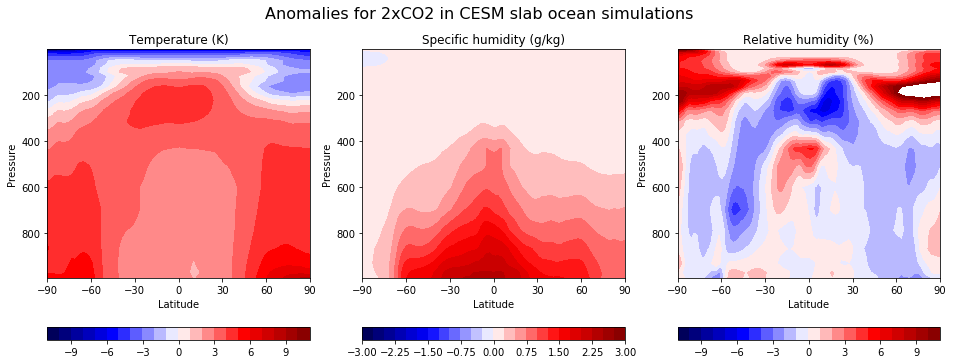

In [6]:
fig

### What do you see here?

- Where does the largest warming occur?
- Where does the largest moistening occur?

In fact the specific humidity anomaly has roughly the same shape of the specific humidity field itself -- **it is largest where the temperature is highest**. This is a consequence of the Clausius-Clapeyron relation.

The **relative humidity** anomaly is

- overall rather small (just a few percent)
- Largest in places cold places where the specific humidity is very small.

The smallness of the relative humidity change is a rather remarkable result.

This is not something we can derive from first principles. It is an emergent property of the GCMs. However it is a very robust feature of global warming simulations.

____________
<a id='section4'></a>

## 4. A simple water vapor parameterization
____________

### A credible climate model needs a water vapor feedback

If relative humidity is nearly constant under global warming, and water vapor is a greenhouse gas, this implies a positive feedback that will amplify the warming for a given radiative forcing.

Thus far our simple models have ignored this process, and we have not been able to use them to assess the climate sensitivity.

To proceed towards more realistic models, we have two options:

- **Simulate** all the evaporation, condensation and transport processes that determine the time-mean water vapor field (as is done in the CESM).
- **Parameterize** the dependence of water vapor on temperature by insisting that relative humidity stays constant as the climate changes.

We will now explore this second option, so that we can continue to think of the global energy budget under climate change as a process occurring in a single column.

### Manabe's constant relative humidity parameterization

We are going to adopt a parameterization first used in a very famous paper:

> Manabe, S. and Wetherald, R. T. (1967). Thermal equilibrium of the atmosphere with a given distribution of relative humidity. J. Atmos. Sci., 24(3):241–259.

This paper was the first to give a really credible calculation of climate sensitivity to a doubling of CO2 by accounting for the known spectral properties of CO2 and H2O absorption, as well as the water vapor feedback!

The parameterization is very simple:

We assume that the relative humidity $r$ is a linear function of pressure $p$:

$$ r = r_s \left( \frac{p/p_s - 0.02}{1 - 0.02} \right) $$

where $p_s = 1000$ hPa is the surface pressure, and $r_s$ is a prescribed surface value of relative humidity. Manabe and Wetherald set $r_s = 0.77$, but we should consider this a tunable parameter in our parameterization.

Since this formula gives a negative number above 20 hPa, we also assume that the **specific humidity** has a minimum value of $0.005$ g/kg (a typical stratospheric value).

This formula is implemented in `climlab.radiation.ManabeWaterVapor()`

Using this parameterization, the surface and tropospheric specific humidity will always increase as the temperature increases.

____________
<a id='section5'></a>

## 5. Modeling spectral bands with the `climlab.BandRCModel` process
____________

Here is a brief introduction to the `climlab.BandRCModel` process.

This is a model that divides the spectrum into 7 distinct bands: three shortwave and four longwave.

As we will see, the process works much like the familiar `climlab.RadiativeConvectiveModel`.

## About the spectra

### Shortwave

The shortwave is divided into three channels:

- Channel 0 is the Hartley and Huggins band (extreme UV, 200 - 340 nm, 1% of total flux, strong ozone absorption)
- Channel 1 is Chappuis band (450 - 800 nm, 27% of total flux, moderate ozone absorption)
- Channel 2 is remaining radiation (72% of total flux, largely in the visible range, no ozone absorption)




### Longwave

The longwave is divided into four bands:

- Band 0 is the **window region** (between 8.5 and 11 $\mu$m), 17% of total flux.
- Band 1 is the CO2 absorption channel (the band of strong absorption by CO2 around 15 $\mu$m), 15% of total flux
- Band 2 is a weak water vapor absorption channel, 35% of total flux
- Band 3 is a strong water vapor absorption channel, 33% of total flux

The longwave decomposition is not as easily related to specific wavelengths, as in reality there is a lot of overlap between H$_2$O and CO$_2$ absorption features (as well as absorption by other greenhouse gases such as CH$_4$ and N$_2$O that we are not representing).

### Example usage of the spectral model

In [7]:
import climlab
from climlab import constants as const

First try a model with all default parameters. Usage is very similar to the familiar `RadiativeConvectiveModel`.

In [8]:
col1 = climlab.BandRCModel()
print( col1)

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



Check out the list of subprocesses.

We now have a process called `H2O`, in addition to things we've seen before.

The state variables are still just temperatures:

In [9]:
col1.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.        , 202.68965517, 205.37931034, 208.06896552,
       210.75862069, 213.44827586, 216.13793103, 218.82758621,
       221.51724138, 224.20689655, 226.89655172, 229.5862069 ,
       232.27586207, 234.96551724, 237.65517241, 240.34482759,
       243.03448276, 245.72413793, 248.4137931 , 251.10344828,
       253.79310345, 256.48275862, 259.17241379, 261.86206897,
       264.55172414, 267.24137931, 269.93103448, 272.62068966,
       275.31034483, 278.        ])})

But the model has a new input field for specific humidity:

In [10]:
col1.q

Field([5.00000000e-06, 5.00000000e-06, 5.00000000e-06, 5.00000000e-06,
       5.87957411e-06, 8.55682965e-06, 1.22193649e-05, 1.71932832e-05,
       2.38916443e-05, 3.28354282e-05, 4.46774859e-05, 6.02302082e-05,
       8.04974602e-05, 1.06711275e-04, 1.40373783e-04, 1.83304857e-04,
       2.37695932e-04, 3.06170488e-04, 3.91851633e-04, 4.98437246e-04,
       6.30283118e-04, 7.92494475e-04, 9.91026303e-04, 1.23279279e-03,
       1.52578624e-03, 1.87920573e-03, 2.30359570e-03, 2.81099479e-03,
       3.41509495e-03, 4.13141097e-03])

The `H2O` process sets the specific humidity field at every timestep to a specified profile, determined by air temperatures. More on that below. For now, let's compute a radiative equilibrium state.

In [11]:
col1.integrate_years(2)

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


In [12]:
# Check for energy balance
col1.ASR - col1.OLR

Field([-0.00148377])

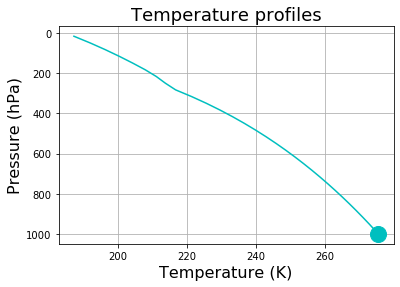

In [13]:
fig, ax = plt.subplots()
ax.plot( col1.Tatm, col1.lev, 'c-', label='default' )
ax.plot( col1.Ts, climlab.constants.ps, 'co', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_title('Temperature profiles', fontsize = 18)
ax.grid()
fig

By default this model has convective adjustment.  We can set the adjusted lapse rate by passing a parameter when we create the model.

The model currently has no ozone (so there is no stratosphere). Not very realistic!


### About the radiatively active gases

The Band model is aware of three different absorbing gases: O3 (ozone), CO2, and H2O (water vapor). The abundances of these gases are stored in a dictionary of arrays as follows:

In [14]:
col1.absorber_vmr

{'CO2': Field([0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038]),
 'O3': Field([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'H2O': Field([5.00000000e-06, 5.00000000e-06, 5.00000000e-06, 5.00000000e-06,
        5.00000000e-06, 5.00000000e-06, 6.38590233e-06, 9.08848690e-06,
        1.33273826e-05, 2.34389689e-05, 3.84220914e-05, 5.95564299e-05,
        8.82144990e-05, 1.25843839e-04, 1.73951159e-04, 2.34088411e-04,
        3.07840683e-04, 3.96815735e-04, 5.02635028e-04, 6.26926041e-04,
        7.71315753e-04, 9.37425100e-04, 1.12686431e-03, 1.34122899e-03,
        1.58209684e-03, 1.85102493e-03, 2.14954752e-03, 2.47917415e-03,
        2.84138824e-03, 3.

Ozone and CO2 are both specified in the model. The default, as you see above, is zero ozone, and constant (well-mixed) CO2 at a volume mixing ratio of 3.8E-4 or 380 ppm.

Water vapor is handled differently: it is determined by the model at each timestep. We make the following assumptions, following a classic paper on radiative-convective equilibrium by Manabe and Wetherald (J. Atmos. Sci. 1967):

- the relative humidity just above the surface is fixed at 77% (can be changed of course... see the parameter `col1.relative_humidity`
- water vapor drops off linearly with pressure
- there is a small specified amount of water vapor in the stratosphere.

## Putting in some ozone

We need to provide some ozone data to the model in order to simulate a stratosphere. We will read in some ozone data just as we did in [Lecture 8](./Lecture08 -- Grey radiation modeling with climlab.ipynb).

In [15]:
ozone = xr.open_dataset( datapath + 'som_input/ozone_1.9x2.5_L26_2000clim_c091112.nc')

In [16]:
#  Take global, annual average and convert to Kelvin
weight_ozone = cos(deg2rad(ozone.lat)) / cos(deg2rad(ozone.lat)).mean(dim='lat')
O3_global = (ozone.O3 * weight_ozone).mean(dim=('lat','lon','time'))
print(O3_global)

<xarray.DataArray (lev: 26)>
array([7.827929e-06, 8.641505e-06, 7.589400e-06, 5.245671e-06, 3.177616e-06,
       1.823200e-06, 9.807570e-07, 6.228705e-07, 4.476205e-07, 3.344812e-07,
       2.625703e-07, 2.078981e-07, 1.570746e-07, 1.124255e-07, 8.060050e-08,
       6.278265e-08, 5.429906e-08, 4.995061e-08, 4.600757e-08, 4.229778e-08,
       3.805591e-08, 3.387686e-08, 3.121716e-08, 2.978071e-08, 2.879810e-08,
       2.754299e-08])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6


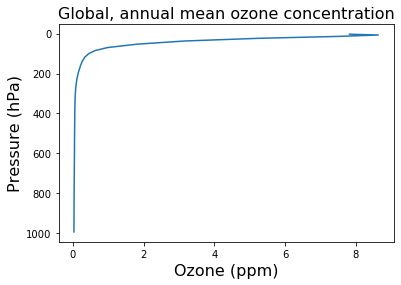

In [17]:
fig, ax = plt.subplots()
ax.plot( O3_global*1E6, ozone.lev)
ax.invert_yaxis()
ax.set_xlabel('Ozone (ppm)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_title('Global, annual mean ozone concentration', fontsize = 16);
fig

We are going to create another instance of the model, this time using the same vertical coordinates as the ozone data.

In [18]:
#  Create the column with appropriate vertical coordinate, surface albedo and convective adjustment
col2 = climlab.BandRCModel(lev=ozone.lev)
print( col2)

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



In [19]:
#  Set the ozone mixing ratio
col2.absorber_vmr['O3'] = O3_global.values

In [20]:
#  Run the model out to equilibrium!
col2.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.9986737567564754 years.


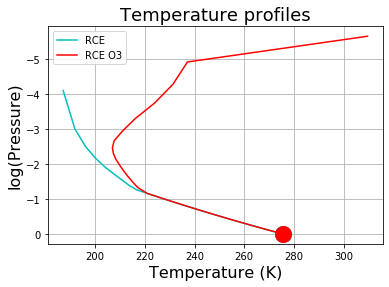

In [21]:
fig, ax = plt.subplots()
ax.plot( col1.Tatm, np.log(col1.lev/1000), 'c-', label='RCE' )
ax.plot( col1.Ts, 0, 'co', markersize=16 )
ax.plot(col2.Tatm, np.log(col2.lev/1000), 'r-', label='RCE O3' )
ax.plot(col2.Ts, 0, 'ro', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('log(Pressure)', fontsize=16 )
ax.set_title('Temperature profiles', fontsize = 18)
ax.grid(); ax.legend()
fig

Once we include ozone we get a well-defined stratosphere. 

Things to consider / try:

- Here we used the global annual mean Q = 341.3 W m$^{-2}$. We might want to consider latitudinal or seasonal variations in Q.
- We also used the global annual mean ozone profile! Ozone varies tremendously in latitude and by season. That information is all contained in the ozone data file we opened above. We might explore the effects of those variations.
- We can calculate climate sensitivity in this model by doubling the CO2 concentration and re-running out to the new equilibrium. Does the amount of ozone affect the climate sensitivity?  (example below)
- An important shortcoming of the model: there are no clouds! (that would be the next step in the hierarchy of column models)
- Clouds would act both in the shortwave (increasing the albedo, cooling the climate) and in the longwave (greenhouse effect, warming the climate). Which effect is stronger depends on the vertical structure of the clouds (high or low clouds) and their optical properties (e.g. thin cirrus clouds are nearly transparent to solar radiation but are good longwave absorbers).

In [22]:
col3 = climlab.process_like(col2)
print( col3)

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



In [23]:
# Let's double CO2.
col3.absorber_vmr['CO2'] *= 2.

In [24]:
col3.compute_diagnostics()
print( 'The radiative forcing for doubling CO2 is %f W/m2.' % (col2.diagnostics['OLR'] - col3.diagnostics['OLR']))

The radiative forcing for doubling CO2 is 1.390262 W/m2.


In [25]:
col3.integrate_years(3)

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 4.996684391891189 years.


In [26]:
col3.ASR - col3.OLR

Field([4.25509398e-07])

In [27]:
print( 'The Equilibrium Climate Sensitivity is %f K.' % (col3.Ts - col2.Ts))

The Equilibrium Climate Sensitivity is 2.790202 K.


In [28]:
#  An example with no ozone
col4 = climlab.process_like(col1)
print( col4)

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



In [29]:
col4.absorber_vmr['CO2'] *= 2.
col4.compute_diagnostics()
print( 'The radiative forcing for doubling CO2 is %f W/m2.' % (col1.OLR - col4.OLR))

The radiative forcing for doubling CO2 is 4.421081 W/m2.


In [30]:
col4.integrate_years(3.)
col4.ASR - col4.OLR

Integrating for 1095 steps, 1095.7266 days, or 3.0 years.
Total elapsed time is 4.996684391891189 years.


Field([-5.25654883e-07])

In [31]:
print( 'The Equilibrium Climate Sensitivity is %f K.' % (col4.Ts - col1.Ts))

The Equilibrium Climate Sensitivity is 3.180993 K.


Interesting that the model is MORE sensitive when ozone is set to zero.

<div class="alert alert-success">
[Back to ATM 623 notebook home](../index.ipynb)
</div>

____________
## Version information
____________



In [32]:
%load_ext version_information
%version_information numpy, matplotlib, xarray, climlab

Software versions
Python 3.7.3 64bit [Clang 9.0.0 (tags/RELEASE_900/final)]
IPython 7.10.1
OS Darwin 17.7.0 x86_64 i386 64bit
numpy 1.17.3
matplotlib 3.1.2
xarray 0.12.1
climlab 0.7.5
Wed Dec 11 13:54:40 2019 PST

____________

## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php)

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________